In [1]:
import json, requests
import nltk
import re
from nltk.corpus import sentiwordnet as swn
import time
import timeit
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
import pandas as pd
import numpy as np
import urllib.request, urllib.parse, urllib.error
import datetime

import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import zscore

from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

from transformers import pipeline


# Column (Y Axis) vs Index (X Axis) Index equals row

In [2]:
bitcoin = pd.read_csv("C:\\Users\\mgall\\OneDrive\\Desktop\\bitcoin.csv")

In [3]:
# Drop URL
bitcoin = bitcoin.drop('url', 1)

In [4]:
# Drop URL Images
bitcoin = bitcoin.drop('urlToImage', 1)

In [5]:
# Drop Source
bitcoin = bitcoin.drop('source', 1)

In [6]:
# Drop Author
bitcoin = bitcoin.drop('author', 1)

In [7]:
bitcoin = bitcoin.drop('description', 1)

In [8]:
bitcoin = bitcoin.drop('content', 1)

In [9]:
bitcoin = bitcoin.rename(columns={'title': 'Sentence'})

In [10]:
bitcoin = bitcoin.rename(columns={'publishedAt': 'Time'})

In [11]:
txt = bitcoin

In [12]:
txt

,Sentence,Time
0,Travelex Reportedly Paid Ransomware Hackers 28...,2020-04-09T21:40:00Z
1,WSJ: Travelex paid ransomware ring $2.3 million,2020-04-09T23:39:27Z
2,Satoshi Nakaboto: ‘Bitcoin and S&P 500 Index h...,2020-03-31T10:07:07Z
3,Satoshi Nakaboto: ‘Binance launches Bitcoin mi...,2020-04-28T10:16:38Z
4,Satoshi Nakaboto: ‘Exchanges see 10% of Bitcoi...,2020-04-15T09:03:30Z
...,...,...
95,Bitcoin’s Huge Surge This Week Could Be The Ti...,2020-04-04T10:00:55Z
96,Coinbase Co-Founder Invests In Project To Brid...,2020-04-03T22:18:09Z
97,Visa Is About To Make Bitcoin Spending Easier ...,2020-04-13T07:57:31Z
98,Just One Major Cryptocurrency Is Outperforming...,2020-04-03T06:39:25Z


In [13]:
#### SORT

txt = txt.sort_values(by='Time', ascending=True)
txt

,Sentence,Time
44,The Official Pablo Escobar Phone Saga Is Bonkers,2020-03-29T07:00:00Z
14,Satoshi Nakaboto: ‘Bitcoin is now worth as muc...,2020-03-30T10:25:24Z
46,Crypto Traders See Bitcoin (But Not Ethereum) ...,2020-03-30T11:24:39Z
41,"'A glimmer of hope': Stocks, oil jump on signs...",2020-03-31T10:05:03Z
2,Satoshi Nakaboto: ‘Bitcoin and S&P 500 Index h...,2020-03-31T10:07:07Z
...,...,...
70,Get set for Bitcoin ‘halving’! Here’s what tha...,2020-04-27T10:47:17Z
75,"Bitcoin, The 2020 Crash, Gold And Hyperinflation",2020-04-27T13:32:34Z
30,New Android ransomware threatens to ‘expose’ y...,2020-04-28T10:00:51Z
3,Satoshi Nakaboto: ‘Binance launches Bitcoin mi...,2020-04-28T10:16:38Z


In [14]:
# Remove Z

txt['Time'] = txt['Time'].map(lambda x: x.rstrip('Z'))
txt

,Sentence,Time
44,The Official Pablo Escobar Phone Saga Is Bonkers,2020-03-29T07:00:00
14,Satoshi Nakaboto: ‘Bitcoin is now worth as muc...,2020-03-30T10:25:24
46,Crypto Traders See Bitcoin (But Not Ethereum) ...,2020-03-30T11:24:39
41,"'A glimmer of hope': Stocks, oil jump on signs...",2020-03-31T10:05:03
2,Satoshi Nakaboto: ‘Bitcoin and S&P 500 Index h...,2020-03-31T10:07:07
...,...,...
70,Get set for Bitcoin ‘halving’! Here’s what tha...,2020-04-27T10:47:17
75,"Bitcoin, The 2020 Crash, Gold And Hyperinflation",2020-04-27T13:32:34
30,New Android ransomware threatens to ‘expose’ y...,2020-04-28T10:00:51
3,Satoshi Nakaboto: ‘Binance launches Bitcoin mi...,2020-04-28T10:16:38


In [15]:
# Remove T

txt['Time']= txt['Time'].str.replace('T', ' ')
txt

,Sentence,Time
44,The Official Pablo Escobar Phone Saga Is Bonkers,2020-03-29 07:00:00
14,Satoshi Nakaboto: ‘Bitcoin is now worth as muc...,2020-03-30 10:25:24
46,Crypto Traders See Bitcoin (But Not Ethereum) ...,2020-03-30 11:24:39
41,"'A glimmer of hope': Stocks, oil jump on signs...",2020-03-31 10:05:03
2,Satoshi Nakaboto: ‘Bitcoin and S&P 500 Index h...,2020-03-31 10:07:07
...,...,...
70,Get set for Bitcoin ‘halving’! Here’s what tha...,2020-04-27 10:47:17
75,"Bitcoin, The 2020 Crash, Gold And Hyperinflation",2020-04-27 13:32:34
30,New Android ransomware threatens to ‘expose’ y...,2020-04-28 10:00:51
3,Satoshi Nakaboto: ‘Binance launches Bitcoin mi...,2020-04-28 10:16:38


In [16]:
txt[['Date','Time']] = txt.Time.str.split(" ",expand=True,)
txt

,Sentence,Time,Date
44,The Official Pablo Escobar Phone Saga Is Bonkers,07:00:00,2020-03-29
14,Satoshi Nakaboto: ‘Bitcoin is now worth as muc...,10:25:24,2020-03-30
46,Crypto Traders See Bitcoin (But Not Ethereum) ...,11:24:39,2020-03-30
41,"'A glimmer of hope': Stocks, oil jump on signs...",10:05:03,2020-03-31
2,Satoshi Nakaboto: ‘Bitcoin and S&P 500 Index h...,10:07:07,2020-03-31
...,...,...,...
70,Get set for Bitcoin ‘halving’! Here’s what tha...,10:47:17,2020-04-27
75,"Bitcoin, The 2020 Crash, Gold And Hyperinflation",13:32:34,2020-04-27
30,New Android ransomware threatens to ‘expose’ y...,10:00:51,2020-04-28
3,Satoshi Nakaboto: ‘Binance launches Bitcoin mi...,10:16:38,2020-04-28


In [17]:
txt[['Hour','Minute', 'Second']] = txt.Time.str.split(":",expand=True,)
txt

,Sentence,Time,Date,Hour,Minute,Second
44,The Official Pablo Escobar Phone Saga Is Bonkers,07:00:00,2020-03-29,07,00,00
14,Satoshi Nakaboto: ‘Bitcoin is now worth as muc...,10:25:24,2020-03-30,10,25,24
46,Crypto Traders See Bitcoin (But Not Ethereum) ...,11:24:39,2020-03-30,11,24,39
41,"'A glimmer of hope': Stocks, oil jump on signs...",10:05:03,2020-03-31,10,05,03
2,Satoshi Nakaboto: ‘Bitcoin and S&P 500 Index h...,10:07:07,2020-03-31,10,07,07
...,...,...,...,...,...,...
70,Get set for Bitcoin ‘halving’! Here’s what tha...,10:47:17,2020-04-27,10,47,17
75,"Bitcoin, The 2020 Crash, Gold And Hyperinflation",13:32:34,2020-04-27,13,32,34
30,New Android ransomware threatens to ‘expose’ y...,10:00:51,2020-04-28,10,00,51
3,Satoshi Nakaboto: ‘Binance launches Bitcoin mi...,10:16:38,2020-04-28,10,16,38


In [18]:
# Initialize NLTK's sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()
# create lists to append our sentiment scores too
sen = []
neg = []
neu = []
pos = []
com = []
# Iterate through all the post titles in our DataFrame
for sentence in txt['Sentence']:
    sen.append(sentence)
    neg.append(list(sid.polarity_scores(sentence).values())[0])
    neu.append(list(sid.polarity_scores(sentence).values())[1])
    pos.append(list(sid.polarity_scores(sentence).values())[2])
    com.append(list(sid.polarity_scores(sentence).values())[3])
# convert all the lists to NumPy array's
sen = np.array(sen)
neg = np.array(neg)
neu = np.array(neu)
pos = np.array(pos)
com = np.array(com)
# create a DataFrame with all of our Sentiment Scores
df = pd.DataFrame({'Sentence' : sen, 'Negative' : neg, 'Neutral' : neu, 'Positive' : pos, 'Compound' : com})
df = df.set_index('Sentence')
# Merge our original DataFrame (txt) with our DataFrame containing the sentiment of the post title's
txt = txt.set_index('Sentence')
txt = txt.join(df)

In [19]:
txt = txt.reset_index()
txt

,Sentence,Time,Date,Hour,Minute,Second,Negative,Neutral,Positive,Compound
0,The Official Pablo Escobar Phone Saga Is Bonkers,07:00:00,2020-03-29,07,00,00,0.000,1.000,0.000,0.0000
1,Satoshi Nakaboto: ‘Bitcoin is now worth as muc...,10:25:24,2020-03-30,10,25,24,0.000,0.826,0.174,0.2263
2,Crypto Traders See Bitcoin (But Not Ethereum) ...,11:24:39,2020-03-30,11,24,39,0.000,1.000,0.000,0.0000
3,"'A glimmer of hope': Stocks, oil jump on signs...",10:05:03,2020-03-31,10,05,03,0.107,0.779,0.115,0.0516
4,Satoshi Nakaboto: ‘Bitcoin and S&P 500 Index h...,10:07:07,2020-03-31,10,07,07,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...
95,Get set for Bitcoin ‘halving’! Here’s what tha...,10:47:17,2020-04-27,10,47,17,0.000,1.000,0.000,0.0000
96,"Bitcoin, The 2020 Crash, Gold And Hyperinflation",13:32:34,2020-04-27,13,32,34,0.310,0.690,0.000,-0.4019
97,New Android ransomware threatens to ‘expose’ y...,10:00:51,2020-04-28,10,00,51,0.191,0.809,0.000,-0.3818
98,Satoshi Nakaboto: ‘Binance launches Bitcoin mi...,10:16:38,2020-04-28,10,16,38,0.000,1.000,0.000,0.0000


In [20]:
#txt = txt.sort_values(by='Time', ascending=False)

In [21]:
txt

,Sentence,Time,Date,Hour,Minute,Second,Negative,Neutral,Positive,Compound
0,The Official Pablo Escobar Phone Saga Is Bonkers,07:00:00,2020-03-29,07,00,00,0.000,1.000,0.000,0.0000
1,Satoshi Nakaboto: ‘Bitcoin is now worth as muc...,10:25:24,2020-03-30,10,25,24,0.000,0.826,0.174,0.2263
2,Crypto Traders See Bitcoin (But Not Ethereum) ...,11:24:39,2020-03-30,11,24,39,0.000,1.000,0.000,0.0000
3,"'A glimmer of hope': Stocks, oil jump on signs...",10:05:03,2020-03-31,10,05,03,0.107,0.779,0.115,0.0516
4,Satoshi Nakaboto: ‘Bitcoin and S&P 500 Index h...,10:07:07,2020-03-31,10,07,07,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...
95,Get set for Bitcoin ‘halving’! Here’s what tha...,10:47:17,2020-04-27,10,47,17,0.000,1.000,0.000,0.0000
96,"Bitcoin, The 2020 Crash, Gold And Hyperinflation",13:32:34,2020-04-27,13,32,34,0.310,0.690,0.000,-0.4019
97,New Android ransomware threatens to ‘expose’ y...,10:00:51,2020-04-28,10,00,51,0.191,0.809,0.000,-0.3818
98,Satoshi Nakaboto: ‘Binance launches Bitcoin mi...,10:16:38,2020-04-28,10,16,38,0.000,1.000,0.000,0.0000


In [22]:
#txt['Time']= txt['Time'].str.replace(':', '')
#txt

In [23]:
t = txt.Sentence
t

0      The Official Pablo Escobar Phone Saga Is Bonkers
1     Satoshi Nakaboto: ‘Bitcoin is now worth as muc...
2     Crypto Traders See Bitcoin (But Not Ethereum) ...
3     'A glimmer of hope': Stocks, oil jump on signs...
4     Satoshi Nakaboto: ‘Bitcoin and S&P 500 Index h...
                            ...                        
95    Get set for Bitcoin ‘halving’! Here’s what tha...
96     Bitcoin, The 2020 Crash, Gold And Hyperinflation
97    New Android ransomware threatens to ‘expose’ y...
98    Satoshi Nakaboto: ‘Binance launches Bitcoin mi...
99    This Bitcoin Rival Is Suddenly Rocketing—Up 75...
Name: Sentence, Length: 100, dtype: object

In [24]:
!pip install transformers
from transformers import pipeline

# Allocate a pipeline for sentiment-analysis
nlp = pipeline('sentiment-analysis')

Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-finetuned-sst-2-english-modelcard.json' to download model card file.
Creating an empty model card.


In [25]:
import time
sentiments = []

start = time.time()
for i in range(len(t)):
    sentiments.append(nlp(t[i]))
    if i % 1 == 0:
        print(i, time.time() - start)
        start = time.time()

0 0.10593891143798828
1 0.10493755340576172
2 0.12992191314697266
3 0.13591766357421875
4 0.11993145942687988
5 0.07595276832580566
6 0.10193848609924316
7 0.08794736862182617
8 0.09394311904907227
9 0.11193132400512695
10 0.09893989562988281
11 0.10993504524230957
12 0.10751533508300781
13 0.10293841361999512
14 0.11393046379089355
15 0.10293984413146973
16 0.09094476699829102
17 0.07595515251159668
18 0.10693550109863281
19 0.07695460319519043
20 0.09394311904907227
21 0.1359267234802246
22 0.0839533805847168
23 0.089324951171875
24 0.07395577430725098
25 0.08694791793823242
26 0.1209249496459961
27 0.08594775199890137
28 0.1169273853302002
29 0.07495689392089844
30 0.15347623825073242
31 0.08795046806335449
32 0.09794092178344727
33 0.1289200782775879
34 0.09993934631347656
35 0.15826416015625
36 0.09694337844848633
37 0.09994339942932129
38 0.07895302772521973
39 0.09993815422058105
40 0.07595539093017578
41 0.09294390678405762
42 0.07695412635803223
43 0.08995199203491211
44 0.077

In [26]:
sen = pd.DataFrame(sentiments, columns = ['sentiment-sentiment_score'])
sen

,sentiment-sentiment_score
0,"{'label': 'NEGATIVE', 'score': 0.9869203}"
1,"{'label': 'POSITIVE', 'score': 0.9963661}"
2,"{'label': 'POSITIVE', 'score': 0.951648}"
3,"{'label': 'POSITIVE', 'score': 0.99856013}"
4,"{'label': 'NEGATIVE', 'score': 0.9787345}"
...,...
95,"{'label': 'NEGATIVE', 'score': 0.90089476}"
96,"{'label': 'NEGATIVE', 'score': 0.980349}"
97,"{'label': 'NEGATIVE', 'score': 0.99917084}"
98,"{'label': 'POSITIVE', 'score': 0.70802796}"


In [27]:
# Fix Format

final_dataframe_txt_sent_hour = pd.concat([txt, sen], axis=1)

In [28]:
final_dataframe_txt_sent_hour

,Sentence,Time,Date,Hour,Minute,Second,Negative,Neutral,Positive,Compound,sentiment-sentiment_score
0,The Official Pablo Escobar Phone Saga Is Bonkers,07:00:00,2020-03-29,07,00,00,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.9869203}"
1,Satoshi Nakaboto: ‘Bitcoin is now worth as muc...,10:25:24,2020-03-30,10,25,24,0.000,0.826,0.174,0.2263,"{'label': 'POSITIVE', 'score': 0.9963661}"
2,Crypto Traders See Bitcoin (But Not Ethereum) ...,11:24:39,2020-03-30,11,24,39,0.000,1.000,0.000,0.0000,"{'label': 'POSITIVE', 'score': 0.951648}"
3,"'A glimmer of hope': Stocks, oil jump on signs...",10:05:03,2020-03-31,10,05,03,0.107,0.779,0.115,0.0516,"{'label': 'POSITIVE', 'score': 0.99856013}"
4,Satoshi Nakaboto: ‘Bitcoin and S&P 500 Index h...,10:07:07,2020-03-31,10,07,07,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.9787345}"
...,...,...,...,...,...,...,...,...,...,...,...
95,Get set for Bitcoin ‘halving’! Here’s what tha...,10:47:17,2020-04-27,10,47,17,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.90089476}"
96,"Bitcoin, The 2020 Crash, Gold And Hyperinflation",13:32:34,2020-04-27,13,32,34,0.310,0.690,0.000,-0.4019,"{'label': 'NEGATIVE', 'score': 0.980349}"
97,New Android ransomware threatens to ‘expose’ y...,10:00:51,2020-04-28,10,00,51,0.191,0.809,0.000,-0.3818,"{'label': 'NEGATIVE', 'score': 0.99917084}"
98,Satoshi Nakaboto: ‘Binance launches Bitcoin mi...,10:16:38,2020-04-28,10,16,38,0.000,1.000,0.000,0.0000,"{'label': 'POSITIVE', 'score': 0.70802796}"


In [29]:
# Importing Bitcoin Hourly Data

data = pd.read_csv("C:\\Users\\mgall\\OneDrive\\Desktop\\btc_hourly_data.csv")
data

,Time,price,volume,label
0,2020-03-29 00:00:00 UTC,6267.842442,1.198522e+07,6247.057869
1,2020-03-29 01:00:00 UTC,6247.057869,5.321685e+06,6261.529889
2,2020-03-29 02:00:00 UTC,6261.529889,4.621280e+06,6246.503971
3,2020-03-29 03:00:00 UTC,6246.503971,5.201742e+06,6248.227000
4,2020-03-29 04:00:00 UTC,6248.227000,2.732258e+06,6224.275820
...,...,...,...,...
572,2020-04-21 20:00:00 UTC,6904.699602,6.890824e+06,6920.943344
573,2020-04-21 21:00:00 UTC,6920.943344,6.827119e+06,6918.690548
574,2020-04-21 22:00:00 UTC,6918.690548,7.082099e+06,6899.936226
575,2020-04-21 23:00:00 UTC,6899.936226,7.333136e+06,6868.601651


In [30]:
X = data
X

,Time,price,volume,label
0,2020-03-29 00:00:00 UTC,6267.842442,1.198522e+07,6247.057869
1,2020-03-29 01:00:00 UTC,6247.057869,5.321685e+06,6261.529889
2,2020-03-29 02:00:00 UTC,6261.529889,4.621280e+06,6246.503971
3,2020-03-29 03:00:00 UTC,6246.503971,5.201742e+06,6248.227000
4,2020-03-29 04:00:00 UTC,6248.227000,2.732258e+06,6224.275820
...,...,...,...,...
572,2020-04-21 20:00:00 UTC,6904.699602,6.890824e+06,6920.943344
573,2020-04-21 21:00:00 UTC,6920.943344,6.827119e+06,6918.690548
574,2020-04-21 22:00:00 UTC,6918.690548,7.082099e+06,6899.936226
575,2020-04-21 23:00:00 UTC,6899.936226,7.333136e+06,6868.601651


In [31]:
date12 = []
hour1 = []
price1 = []
label1 = []
volume1 = []
for i in range(len(X)):
    date12.append(X.Time[i][:10])
    hour1.append(X.Time[i][11:13])
    price1.append(X.price[i])
    label1.append(X.label[i])
    volume1.append(X.volume[i])
    
dt = pd.DataFrame(date12, columns = ['Date1'])
hr = pd.DataFrame(hour1, columns = ['hour1'])
pr = pd.DataFrame(price1, columns = ['price1'])
lb = pd.DataFrame(label1, columns = ['label1'])
vol = pd.DataFrame(volume1, columns= ['volume1'])
new_data = pd.concat([dt, hr, pr, lb, vol], axis=1)

In [32]:
new_data1 = new_data

In [33]:
fi = final_dataframe_txt_sent_hour.loc[(final_dataframe_txt_sent_hour['Date'].isin(new_data['Date1']))] 
fi = fi.reset_index().drop(columns = ['index'])

In [34]:
f2 = fi.drop(columns = ['Time', 'Negative', 'Neutral', 'Positive', 'Compound'])

In [35]:
f2.reset_index().drop(columns = ['index']).to_csv("final.csv", index=False)

In [36]:
text_plus_non_text = pd.concat([fi, new_data1], axis=1).dropna()
text_plus_non_text

,Sentence,Time,Date,Hour,Minute,Second,Negative,Neutral,Positive,Compound,sentiment-sentiment_score,Date1,hour1,price1,label1,volume1
0,The Official Pablo Escobar Phone Saga Is Bonkers,07:00:00,2020-03-29,07,00,00,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.9869203}",2020-03-29,00,6267.842442,6247.057869,1.198522e+07
1,Satoshi Nakaboto: ‘Bitcoin is now worth as muc...,10:25:24,2020-03-30,10,25,24,0.000,0.826,0.174,0.2263,"{'label': 'POSITIVE', 'score': 0.9963661}",2020-03-29,01,6247.057869,6261.529889,5.321685e+06
2,Crypto Traders See Bitcoin (But Not Ethereum) ...,11:24:39,2020-03-30,11,24,39,0.000,1.000,0.000,0.0000,"{'label': 'POSITIVE', 'score': 0.951648}",2020-03-29,02,6261.529889,6246.503971,4.621280e+06
3,"'A glimmer of hope': Stocks, oil jump on signs...",10:05:03,2020-03-31,10,05,03,0.107,0.779,0.115,0.0516,"{'label': 'POSITIVE', 'score': 0.99856013}",2020-03-29,03,6246.503971,6248.227000,5.201742e+06
4,Satoshi Nakaboto: ‘Bitcoin and S&P 500 Index h...,10:07:07,2020-03-31,10,07,07,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.9787345}",2020-03-29,04,6248.227000,6224.275820,2.732258e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,Typosquatting RubyGems laced with Bitcoin-nabb...,09:45:12,2020-04-21,09,45,12,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.9986516}",2020-04-01,05,6359.996272,6343.719354,7.092367e+06
78,The 2 Things About Marketing That Never Change,14:00:00,2020-04-21,14,00,00,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.9468405}",2020-04-01,06,6343.719354,6360.191122,9.957620e+06
79,Exclusive Interview: NFL Linebacker Russell Ok...,16:08:50,2020-04-21,16,08,50,0.000,0.919,0.081,0.1280,"{'label': 'NEGATIVE', 'score': 0.9721771}",2020-04-01,07,6360.191122,6347.819906,5.979936e+06
80,Billionaire Mark Cuban Reveals When He Would B...,23:20:00,2020-04-21,23,20,00,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.78104985}",2020-04-01,08,6347.819906,6332.769962,5.735174e+06


In [37]:
text_plus_non_text.to_csv("text_plus_non_text.csv", index = False)

In [38]:
X = text_plus_non_text.drop(columns = ['Time', 'Negative', 'Minute', 'Second','Neutral','Positive', 'Compound', 'Date1', 'hour1'])
#X = text_plus_non_text.drop(columns = ['Time', 'Negative', 'Neutral','Positive', 'Compound', 'Date1', 'hour1'])

In [39]:
X

,Sentence,Date,Hour,sentiment-sentiment_score,price1,label1,volume1
0,The Official Pablo Escobar Phone Saga Is Bonkers,2020-03-29,07,"{'label': 'NEGATIVE', 'score': 0.9869203}",6267.842442,6247.057869,1.198522e+07
1,Satoshi Nakaboto: ‘Bitcoin is now worth as muc...,2020-03-30,10,"{'label': 'POSITIVE', 'score': 0.9963661}",6247.057869,6261.529889,5.321685e+06
2,Crypto Traders See Bitcoin (But Not Ethereum) ...,2020-03-30,11,"{'label': 'POSITIVE', 'score': 0.951648}",6261.529889,6246.503971,4.621280e+06
3,"'A glimmer of hope': Stocks, oil jump on signs...",2020-03-31,10,"{'label': 'POSITIVE', 'score': 0.99856013}",6246.503971,6248.227000,5.201742e+06
4,Satoshi Nakaboto: ‘Bitcoin and S&P 500 Index h...,2020-03-31,10,"{'label': 'NEGATIVE', 'score': 0.9787345}",6248.227000,6224.275820,2.732258e+06
...,...,...,...,...,...,...,...
77,Typosquatting RubyGems laced with Bitcoin-nabb...,2020-04-21,09,"{'label': 'NEGATIVE', 'score': 0.9986516}",6359.996272,6343.719354,7.092367e+06
78,The 2 Things About Marketing That Never Change,2020-04-21,14,"{'label': 'NEGATIVE', 'score': 0.9468405}",6343.719354,6360.191122,9.957620e+06
79,Exclusive Interview: NFL Linebacker Russell Ok...,2020-04-21,16,"{'label': 'NEGATIVE', 'score': 0.9721771}",6360.191122,6347.819906,5.979936e+06
80,Billionaire Mark Cuban Reveals When He Would B...,2020-04-21,23,"{'label': 'NEGATIVE', 'score': 0.78104985}",6347.819906,6332.769962,5.735174e+06


In [40]:
X['Date'] = X['Date'].astype(str)
X['Hour'] = X['Hour'].astype(float)
X['Hour']

0      7.0
1     10.0
2     11.0
3     10.0
4     10.0
      ... 
77     9.0
78    14.0
79    16.0
80    23.0
81    15.0
Name: Hour, Length: 82, dtype: float64

In [41]:
X['sentiment-sentiment_score'] = X['sentiment-sentiment_score'].astype(str)
X['sentiment-sentiment_score']

0      {'label': 'NEGATIVE', 'score': 0.9869203}
1      {'label': 'POSITIVE', 'score': 0.9963661}
2       {'label': 'POSITIVE', 'score': 0.951648}
3     {'label': 'POSITIVE', 'score': 0.99856013}
4      {'label': 'NEGATIVE', 'score': 0.9787345}
                         ...                    
77     {'label': 'NEGATIVE', 'score': 0.9986516}
78     {'label': 'NEGATIVE', 'score': 0.9468405}
79     {'label': 'NEGATIVE', 'score': 0.9721771}
80    {'label': 'NEGATIVE', 'score': 0.78104985}
81     {'label': 'NEGATIVE', 'score': 0.9989525}
Name: sentiment-sentiment_score, Length: 82, dtype: object

In [42]:
X['sentiment-sentiment_score'][0][31:-1]

'0.9869203'

In [43]:
samples = {}
for i in range(len(X)):  
    temp = X['sentiment-sentiment_score'][i]
    if(temp[11:19] == 'POSITIVE'):
        samples[i] = (1, temp[31:-1])
    else:
        samples[i] = (-1, temp[31:-1])
# print(samples)
data1 = pd.DataFrame.from_dict(samples, orient='index',columns=['Sentiment', 'score'])

In [44]:
data1

,Sentiment,score
0,-1,0.9869203
1,1,0.9963661
2,1,0.951648
3,1,0.99856013
4,-1,0.9787345
...,...,...
77,-1,0.9986516
78,-1,0.9468405
79,-1,0.9721771
80,-1,0.78104985


In [45]:
X_new = pd.concat([X, data1], axis=1)
# X_new.to_csv("X_new.csv", index=False)

In [46]:
#import pandas as pd
#X_new = pd.read_csv("X_new.csv")

In [47]:
# Therefore X1 = data and y1 = label
DATA = X_new.drop(columns = ['sentiment-sentiment_score', 'Sentence'])

y1 = X_new["label1"]

In [48]:
DATA.head()

,Date,Hour,price1,label1,volume1,Sentiment,score
0,2020-03-29,7.0,6267.842442,6247.057869,1.198522e+07,-1,0.9869203
1,2020-03-30,10.0,6247.057869,6261.529889,5.321685e+06,1,0.9963661
2,2020-03-30,11.0,6261.529889,6246.503971,4.621280e+06,1,0.951648
3,2020-03-31,10.0,6246.503971,6248.227000,5.201742e+06,1,0.99856013
4,2020-03-31,10.0,6248.227000,6224.275820,2.732258e+06,-1,0.9787345


In [49]:
X1 = DATA.drop(columns = ['Date', 'Hour', 'label1'])
X1.head()

,price1,volume1,Sentiment,score
0,6267.842442,1.198522e+07,-1,0.9869203
1,6247.057869,5.321685e+06,1,0.9963661
2,6261.529889,4.621280e+06,1,0.951648
3,6246.503971,5.201742e+06,1,0.99856013
4,6248.227000,2.732258e+06,-1,0.9787345


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X1.values, y1.values, shuffle=False, test_size=0.2)

In [51]:
reg = RandomForestRegressor(n_estimators=250, max_depth=100, random_state=28)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

MSE: 1667.8009885952729
MAE: 33.06681417105783


In [52]:
# normalizing the data
#normalized_data = DATA.drop(columns=['Date', 'Hour', 'Sentiment', 'score', 'label1']).apply(zscore)
normalized_data = DATA.drop(columns=['Date', 'Hour', 'Sentiment', 'score']).apply(zscore)

X2 = pd.concat([normalized_data, X1['Sentiment'], X1['score']], axis=1)
# y2 = normalized_data['label1']
mean, std = DATA['label1'].mean(), DATA['label1'].std()
# X2 = X2.drop(columns = ['label1'])
X2.head()

,price1,label1,volume1,Sentiment,score
0,-0.297167,-0.423163,-0.087132,-1,0.9869203
1,-0.417669,-0.339222,-0.776136,1,0.9963661
2,-0.333765,-0.426376,-0.848557,1,0.951648
3,-0.420880,-0.416382,-0.788538,1,0.99856013
4,-0.410891,-0.555303,-1.043880,-1,0.9787345


In [53]:
X2.to_csv("reddit_data_normalized.csv", index=False)

In [54]:
Data_new = pd.read_csv("C:\\Users\\mgall\\OneDrive\\Desktop\\reddit_data_normalized.csv")
Data_new

,price1,label1,volume1,Sentiment,score
0,-0.297167,-0.423163,-0.087132,-1,0.986920
1,-0.417669,-0.339222,-0.776136,1,0.996366
2,-0.333765,-0.426376,-0.848557,1,0.951648
3,-0.420880,-0.416382,-0.788538,1,0.998560
4,-0.410891,-0.555303,-1.043880,-1,0.978734
...,...,...,...,...,...
77,0.237111,0.137494,-0.593049,-1,0.998652
78,0.142743,0.233033,-0.296784,-1,0.946841
79,0.238241,0.161278,-0.708073,-1,0.972177
80,0.166517,0.073985,-0.733382,-1,0.781050


In [55]:
X3 = Data_new.drop(columns =['label1'])
y3 = Data_new.label1

In [56]:
y3.head()

0   -0.423163
1   -0.339222
2   -0.426376
3   -0.416382
4   -0.555303
Name: label1, dtype: float64

MSE: 0.055818309103164404
MAE: 0.19116074412330095


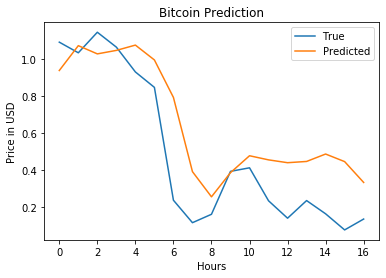

In [57]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X3.values, y3.values, shuffle=False, test_size=0.2)

reg = RandomForestRegressor(n_estimators=250, max_depth=100, random_state=28)
reg.fit(X_train2, y_train2)
y_pred = reg.predict(X_test2)
print('MSE:', mean_squared_error(y_test2, y_pred))
print('MAE:', mean_absolute_error(y_test2, y_pred))

plt.plot(y_test2, label='True')
plt.plot(y_pred, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

In [58]:
y_pred_org = (y_pred * std) + mean
y_test_org = (y_test2 * std) + mean

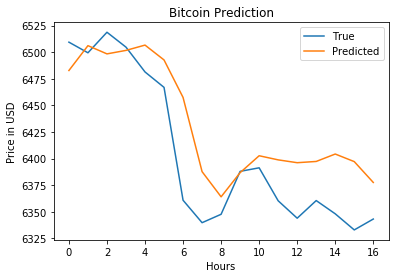

In [59]:
plt.plot(y_test_org, label='True')
plt.plot(y_pred_org, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

In [60]:
print('MSE:', mean_squared_error(y_test_org, y_pred_org))
print('MAE:', mean_absolute_error(y_test_org, y_pred_org))

MSE: 1679.649823341787
MAE: 33.16039907838614


In [61]:
# Applying LSTM
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3.values, y3.values, shuffle=False, test_size=0.2)
X_train3.shape

(65, 4)

In [62]:
X_train3 = X_train3.reshape(X_train3.shape[0], 4 ,1)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

model1 = Sequential()
model1.add(LSTM(128, input_shape=(4,1),return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(32, activation='tanh'))
model1.add(Dense(1, activation='linear'))

model1.compile(optimizer="adam", loss="mean_squared_error")

model1.fit(X_train3, y_train3, epochs=50)

# model1.evaluate(X_test3 , y_test3)

Train on 65 samples
Epoch 1/50
65/65 [==============================] - 5s 83ms/sample - loss: 1.1330
Epoch 2/50
65/65 [==============================] - 0s 907us/sample - loss: 1.0741
Epoch 3/50
65/65 [==============================] - 0s 923us/sample - loss: 1.0222
Epoch 4/50
65/65 [==============================] - 0s 723us/sample - loss: 0.9655
Epoch 5/50
65/65 [==============================] - 0s 660us/sample - loss: 0.8888
Epoch 6/50
65/65 [==============================] - 0s 646us/sample - loss: 0.7979
Epoch 7/50
65/65 [==============================] - 0s 661us/sample - loss: 0.7033
Epoch 8/50
65/65 [==============================] - 0s 723us/sample - loss: 0.5991
Epoch 9/50
65/65 [==============================] - ETA: 0s - loss: 0.677 - 0s 677us/sample - loss: 0.4986
Epoch 10/50
65/65 [==============================] - 0s 723us/sample - loss: 0.4222
Epoch 11/50
65/65 [==============================] - 0s 753us/sample - loss: 0.3767
Epoch 12/50
65/65 [=======================

MSE: 0.04786147534797877
MAE: 0.15113787163739018


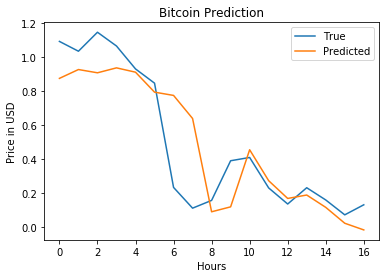

In [63]:
X_test3 = X_test2.reshape(X_test3.shape[0], 4, 1)
y_pred3 = model1.predict(X_test3)
print('MSE:', mean_squared_error(y_test3, y_pred3))
print('MAE:', mean_absolute_error(y_test3, y_pred3))

plt.plot(y_test3, label='True')
plt.plot(y_pred3, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

MSE: 1440.216166067264
MAE: 26.21777055398803


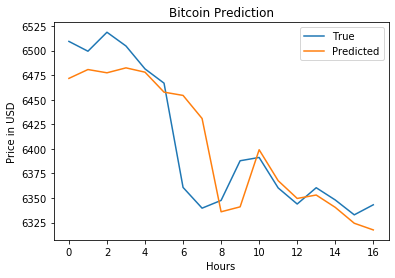

In [64]:
y_pred_org1 = (y_pred3 * std) + mean
y_test_org1 = (y_test3 * std) + mean
print('MSE:', mean_squared_error(y_test_org1, y_pred_org1))
print('MAE:', mean_absolute_error(y_test_org1, y_pred_org1))
plt.plot(y_test_org1, label='True')
plt.plot(y_pred_org1, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

MSE: 0.01957411034206081
MAE: 0.0999789032113582


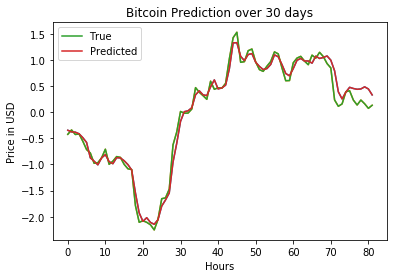

In [65]:
# over the entire 30 days time

pred = reg.predict(X3)
plt.plot(pred)
plt.plot(y3)
print('MSE:', mean_squared_error(y3, pred))
print('MAE:', mean_absolute_error(y3, pred))
plt.plot(y3, label='True')
plt.plot(pred, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction over 30 days')
plt.legend()

MSE: 589.0119479855622
MAE: 17.343206865576697


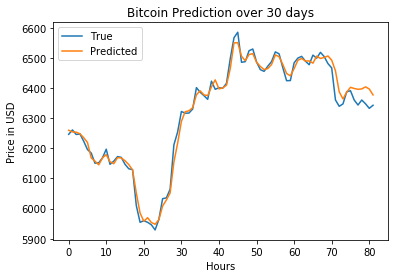

In [66]:
pred_org1 = (pred * std) + mean
y_org1 = (y3 * std) + mean
print('MSE:', mean_squared_error(y_org1, pred_org1))
print('MAE:', mean_absolute_error(y_org1, pred_org1))
plt.plot(y_org1, label='True')
plt.plot(pred_org1, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction over 30 days')
plt.legend()

In [67]:
X_new

,Sentence,Date,Hour,sentiment-sentiment_score,price1,label1,volume1,Sentiment,score
0,The Official Pablo Escobar Phone Saga Is Bonkers,2020-03-29,7.0,"{'label': 'NEGATIVE', 'score': 0.9869203}",6267.842442,6247.057869,1.198522e+07,-1,0.9869203
1,Satoshi Nakaboto: ‘Bitcoin is now worth as muc...,2020-03-30,10.0,"{'label': 'POSITIVE', 'score': 0.9963661}",6247.057869,6261.529889,5.321685e+06,1,0.9963661
2,Crypto Traders See Bitcoin (But Not Ethereum) ...,2020-03-30,11.0,"{'label': 'POSITIVE', 'score': 0.951648}",6261.529889,6246.503971,4.621280e+06,1,0.951648
3,"'A glimmer of hope': Stocks, oil jump on signs...",2020-03-31,10.0,"{'label': 'POSITIVE', 'score': 0.99856013}",6246.503971,6248.227000,5.201742e+06,1,0.99856013
4,Satoshi Nakaboto: ‘Bitcoin and S&P 500 Index h...,2020-03-31,10.0,"{'label': 'NEGATIVE', 'score': 0.9787345}",6248.227000,6224.275820,2.732258e+06,-1,0.9787345
...,...,...,...,...,...,...,...,...,...
77,Typosquatting RubyGems laced with Bitcoin-nabb...,2020-04-21,9.0,"{'label': 'NEGATIVE', 'score': 0.9986516}",6359.996272,6343.719354,7.092367e+06,-1,0.9986516
78,The 2 Things About Marketing That Never Change,2020-04-21,14.0,"{'label': 'NEGATIVE', 'score': 0.9468405}",6343.719354,6360.191122,9.957620e+06,-1,0.9468405
79,Exclusive Interview: NFL Linebacker Russell Ok...,2020-04-21,16.0,"{'label': 'NEGATIVE', 'score': 0.9721771}",6360.191122,6347.819906,5.979936e+06,-1,0.9721771
80,Billionaire Mark Cuban Reveals When He Would B...,2020-04-21,23.0,"{'label': 'NEGATIVE', 'score': 0.78104985}",6347.819906,6332.769962,5.735174e+06,-1,0.78104985


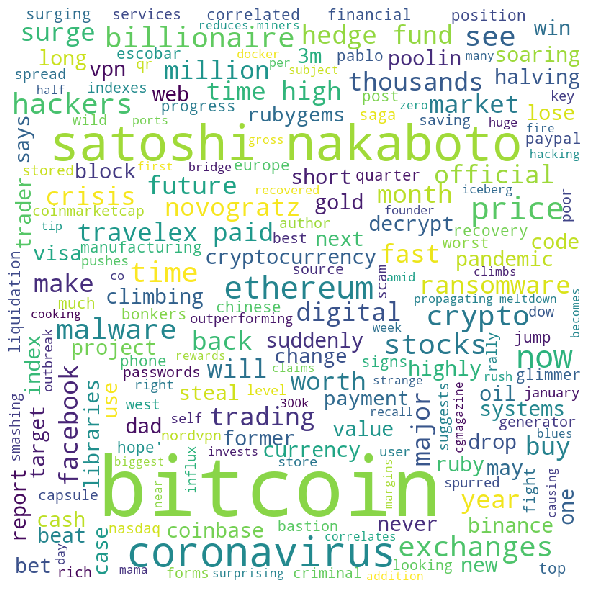

In [68]:
# Reads 'Youtube04-Eminem.csv' file  
df = X_new["Sentence"]
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [69]:
#### Load Shedding Applied

